<center><h1>TP IRM SIMULATION</h1>
<b>Aurélien Trotier</b> : Février 2020
</center>

Le signal IRM peut-être représenté grâce à l'équation de Bloch :

$\frac{d\vec{M}}{dt} = \gamma \vec{M} \times \vec{B}_{ext} + \frac{1}{T_1} (M_0 - M_z)\vec{z} - \frac{1}{T_2} \vec{M}_\perp$

<h3>1. Préparation des sous-fonctions</h3>

Préparez les fonctions nécessaires à la simulation du signal IRM :

- xrot(angle), yrot(angle) et zrot(angle) : qui retourne une matrice de rotation à partir d'un angle (en radian)
- throt(phi,theta) : si l'angle de rotation est transverse (différent de x/y) (utilisez les fonctions précédentes : $Rth(phi,theta)=Rz(theta)*Rx(phi)*Rz(-theta)$)
- freeprecess(T,T1,T2,df) : calcul des opérateurs de relaxation en fonction du T1 et T2, de l'off-resonance de l'isochromat df durant un délai T

Validez que les fonctions fonctionnes bien (affichage d'une flèche avant et après rotation par exemple)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, plot, subplot, title, xlabel, ylabel

from numpy import mean, std, exp, diag, matmul, pi, cos, sin, zeros, ones, shape, floor, ceil
from IPython.display import display

#--------------------------------------------------------
#  By convention all rotations are left-handed
#--------------------------------------------------------

# Returns 3x3 matrix for left-handed rotation about x
def xrot(angle = 0., in_degs = False):
    if in_degs:
        angle = angle*np.pi/180.
    c = np.cos(angle)    
    s = np.sin(angle)    
    M = np.array([[1.,0.,0.],[0., c, -s],[0,s, c]])
    return M

# Returns 3x3 matrix for left-handed rotation about y
def yrot(angle = 0., in_degs = False):
    if in_degs:
        angle = angle*np.pi/180.
    c = np.cos(angle)    
    s = np.sin(angle)    
    M = np.array([[c,0.,s],[0.,1.,0.],[-s,0.,c]])
    return M


# Returns 3x3 matrix for left-handed rotation about z
def zrot(angle = 0., in_degs = False):
    'This is equivalent to help'
    if in_degs:
        angle = angle*np.pi/180.
    c = np.cos(angle)    
    s = np.sin(angle)    
    M = np.array([[c,-s,0.],[s,c,0],[0.,0.,1.]])
    return M


# Returns 3x3 matrix for rotation about axis in x-y plan phi away from x
def throt(theta = 0., phi=0., in_degs = True):
    'This is equivalent to help'
    if in_degs:
        theta = theta*np.pi/180.
        phi = phi*np.pi/180.
     
# Returns A & B function    
def freeprecess(t,T1 = 4., T2 = 0.1, df = 0):
    T1 = T1 * 1.
    T2 = T2 * 1.
    t = t * 1.
    
    phi = 2*pi*df*t
    E1 = np.exp(-t/T1)
    E2 = np.exp(-t/T2)
    A = matmul(np.diag([E2, E2, E1]),zrot(phi,False))
    B = np.array([0,0,1-E1]) 
       
    B = np.reshape(B,[3,1])
    return A,B

In [11]:

# define plot    
def setprops():
    import matplotlib.style as style
    style.use('seaborn') # 'ggplot'   
    
# Label plot with x,y axis labels, and title.  Turn on grid by default
#
# INPUT:
#	xlab = x-axis label
#	ylab = y-axis label
#	ptitle = plot title
#	ax = plot axis limits (4-tuple)
#	gridon = True to turn on grid
#	legend = True to turn on legend
#
def lplot(xlab = None,ylab = None, ptitle = None,ax = None,gridon = True,legend=False):
    if xlab is not None:
      xlabel(xlab)
    if ylab is not None:
      ylabel(ylab)
    if ptitle is not None:
      title(ptitle)
    if ax is not None:
      plt.axis(ax)
    if (gridon is True):
      plt.grid(gridon)
    if (legend is True):
      plt.legend()

<h3>2. Signal de précession libre</h3>

Simuler 2 signaux de precession libre (correspondant à l'évolution du signal après une impulsion radiofréquence)  avec une valeur d'off-resonance de 0 ou 10 Hz :

- angle = $$\frac{\pi}{2}$$ correspondant à une aimantation de départ selon l'axe $$\vec{M} = \begin{bmatrix}
  0\\ 
  1\\
  0
  \end{bmatrix}$$  
- Pas de simulation : 1 ms
- Durée de simulation : 1000 ms
- Off-resonance : 0 ou 10 Hz
- T1 = 600 ms
- T2 = 100 ms

<u>Expliquez la différence entre les 2 simulations ?</u>

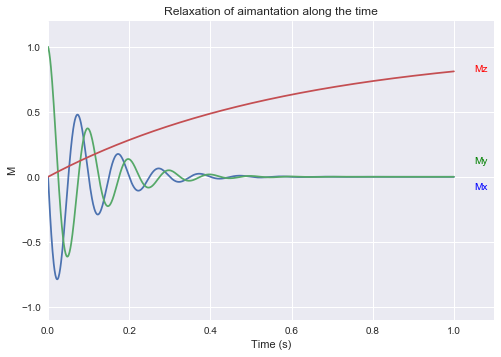

In [14]:
# definition of parameters
dT = 0.001
T = 1
N = int(np.ceil(T/dT))+1
df = 10
T1 = 0.600
T2 = 0.100
df = 10

A,B = freeprecess(dT,T1, T2, df)

# Simulate the decay
M = np.zeros((3, int(N)))

# initiliaze aimantation along x (like flip angle 90°)
M[:,0] = np.array([0,1,0])

# propagate the relaxation along the time
for k in range(1, N):
  M[:,k] = matmul(A,M[:,k-1])+B[:,0]


# Plot of Mz for    
t = np.arange(0, T+dT, dT)
plt.plot(t,M[0,:])
plt.text(1.05, -0.1, 'Mx', horizontalalignment='left', color='blue')

plt.plot(t,M[1,:])
plt.text(1.05, 0.1, 'My', horizontalalignment='left', color='green')

plt.plot(t,M[2,:])
plt.text(1.05, M[2,-1], 'Mz', horizontalalignment='left', color='red')
lplot('Time (s)','M','Relaxation of aimantation along the time',[0, 1.1, -1.1, 1.2]);
setprops()


<h3>3. Echo de gradient</h3>

![Gradient_Echo](../../TP/img/Gradient_Echo.png)

Simuler le signal d'une séquence écho de gradient avec les paramètres ci-dessous :

```df = 0;	% Hz off-resonance.
df = 0;     % Hz
T1 = 600;	  % ms
T2 = 100;	  % ms
TE = 1;     % ms
TR = 500;   % ms
alpha = 60; % deg
```

* Quelle est la valeur de l'aimantation au temps TE après la 1ère impulsion de radiofréquence et après la seconde ? Expliquez la différence.

* Combien de TR sont nécessaire pour atteindre un état d'équilibre ( **steady-state**) que l'on définira ici par une modification du signal inférieur à 1%.
* Calculez la valeur exact de l'état d'équilibre au TR puis au TE. Ecrivez une fonction **[Msig,Mss]=sssignal(flip,T1,T2,TE,TR,dfreq) ** permettant de calculer le signal de steady-state au TE (Mss) et juste la valeur complexe dans le plan : $$Msig = Mss(1)+i*Mss(2)$$

Dans le cas d'une séquence **FLASH** (**F**ast **L**ow **A**ngle **SH**ot) l'aimantation steady-state longitudinal (selon l'axe z) est égale à $$M_{ss}= \frac{M_0(1-E_1)}{1-E_1 \cos \theta} = 0.7224$$ . Cette différence s'explique par le fait que l'aimantation est spoilée à la fin de chaque TR (RF et phase spoiling) donc que l'aimantation transversale (selon x/y) est égale à 0.

* Implémentez le *spoiling* et vérifiez que la valeur correspond à l'équation analytique ci-dessus



<h3>4. Spin echo</h3>
<h5><u>Simulation</u></h5>


![Spin_Echo](../../TP/img/Spin_Echo.png)

Simuler le signal au cours d'un TR et affichez l'aimantation Mx, My et Mz. 

```T1 = 600 ms
T1 = 600  ms
T2 = 100  ms
df = 10   Hz
TR = 500  ms
TE = 50   ms
dT = 1    ms 
```

* Qu'observez vous au temps TE ? Comment être sur que c'est bien un écho de spin ?

Simulez 5 isochromates avec des valeurs différentes d'off-resonance (df) puis affichez  sur le même graphique: La valeur absolue d'un isochromate dans le plan transverse ($M_{Sig}=\sqrt{x^2+y^2}$) la valeur absolue de la somme des isochromates. 

* Expliquez pourquoi la courbe de la somme (divisée par le nombre d'isochromates) croise la courbe de la valeur absolue.

Refaites la même simulation plusieurs fois pour voir les différences et augmenter le nombre d'isochromates dans la simulation



<h5><u>Steady-state</u></h5>

* Calculez le steady state au TE de la séquence Spin-Echo

* Etendre ce calcul pour une séquence Turbo-spin echo (Echo Train Lenght = 8) [voir présentation pour propagation des équations].

  ![Turbo_Spin_Echo](../../TP/img/Turbo_Spin_Echo.png)

* Calculez le steady-state au 1er TE et comparez avec le steady-state de la séquence Spin-Echo. Vérifiez la valeur en mettant un Echo Train Length = 1. Expliquez ce résultat.

  

<h3>OPTIONAL : BSSFP et banding artefacts</h3>

BSSFP est l'acronyme pour "Balanced Steady-State Free Precession". C'est une dans laquelle les gradients sont équilibré (dont la somme au cours du TR = 0)

<img src="../../TP/img/bssfp_sequence.png" alt="bssfp_sequence" style="zoom: 50%;" /><img src="../../TP/img/bssfp.png" alt="bssfp" style="zoom:50%;" />

Cette séquence est donc équivalente à la séquence d'écho de gradient simulé dans la partie 3. Elle a pour particularité d'avoir un fort signal qui est un compromis T1/T2 avec des TRs court ainsi que de généré des **artéfacts de bande noire**.

Pour le simuler il faut prendre un compte l'off-resonance qui peut exister dans un voxel. 